In [1]:
import pandas as pd
import numpy as np
import nltk

In [2]:
def plot_history(history, nEpoch):
    # Plot loss and accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(nEpoch)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.tight_layout()
    plt.show()

In [3]:
#đọc data
df = pd.read_csv("https://raw.githubusercontent.com/huynhthanh98/AML/main/lab-04/spam_detection.csv")
df.head()

,Text,Label,y
0,"Go until jurong point, crazy.. Available only ...",ham,0
1,Ok lar... Joking wif u oni...,ham,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,1
3,U dun say so early hor... U c already then say...,ham,0
4,"Nah I don't think he goes to usf, he lives aro...",ham,0


In [4]:
nltk.download('punkt')
texts = df["Text"].to_list()
texts = [text.lower() for text in texts ]           # chuyển các đoạn text thành chữ thường (word embedding chỉ cho chữ thường)
tokenized_texts = [nltk.tokenize.word_tokenize(text) for text in texts]    # tách câu thành một list các từ

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
print(tokenized_texts[0])


['go', 'until', 'jurong', 'point', ',', 'crazy..', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'cine', 'there', 'got', 'amore', 'wat', '...']


In [6]:
# Tải bộ weights Glove 300d
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2021-11-19 04:18:51--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-11-19 04:18:51--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.21MB/s    in 2m 42s  

2021-11-19 04:21:33 (5.08 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [7]:
#Giải Nén
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [8]:
import io
import numpy as np
def load_word_embeddings(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    vocab, matrix = [], []
    i=0
    for line in fin:
        tokens = line.rstrip().split(' ')
        vocab.append(tokens[0])
        matrix.append(list(map(float, tokens[1:])))
        del tokens
    return vocab, np.asarray(matrix)

In [9]:
vocab, matrix = load_word_embeddings("glove.6B.300d.txt")

In [10]:
matrix.shape

(400000, 300)

In [11]:


## Gán các mã
__PADDED_INDEX__ = 0    # mã dùng cho các vị trí chỉ có tính nối dài cho cùng kích thước
__UNKNOWN_WORD__ = 1    # mã cho những từ không có trong embedding



In [12]:
word_to_index = {word: index+2 for index, word in enumerate(vocab)}


In [13]:
embedding_matrix = np.pad(matrix, ((2,0),(0,0)), mode='constant', constant_values =0.0)
print(embedding_matrix)

[[ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.04656    0.21318   -0.0074364 ...  0.0090611 -0.20989    0.053913 ]
 ...
 [ 0.075713  -0.040502   0.18345   ...  0.21838    0.30967    0.43761  ]
 [ 0.81451   -0.36221    0.31186   ...  0.075486   0.28408   -0.17559  ]
 [ 0.429191  -0.296897   0.15011   ...  0.28975    0.32618   -0.0590532]]


In [14]:
import tensorflow as tf

X = []
for text in tokenized_texts:
    cur_text_indices = []
    for word in text:
        if word in word_to_index:
            cur_text_indices.append(word_to_index[word])    
        else:
            cur_text_indices.append(__UNKNOWN_WORD__)       
    X.append(cur_text_indices)

## pad data cho có cùng chiều dài
X = tf.keras.preprocessing.sequence.pad_sequences(sequences=X,       
                                                  padding='post')    

y = df['y'].values   ## Label của bài toán, 0 là không phải spam, 1 là spam


In [15]:
## Chia data
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size= 0.2, random_state =0)

In [16]:
X_train.shape

(4459, 215)

In [17]:
embedding_matrix.shape

(400002, 300)

In [18]:
from tensorflow.keras.layers import Input, Embedding,Conv1D, LSTM, Bidirectional, Dense, GRU, GlobalAveragePooling1D
from tensorflow.keras.models import Model

inputs = Input(shape=(None,))                  

embed = Embedding(input_dim=embedding_matrix.shape[0],  
                 output_dim=embedding_matrix.shape[1],   
                  embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix), 
                  trainable=False,                       
                 mask_zero=True)(inputs)                 

 
conv1d = Conv1D(filters=100, kernel_size=2, activation='relu')(embed)

global_maxpool = GlobalAveragePooling1D()(conv1d)
dense = Dense(units=2, activation='softmax')(global_maxpool)
model = Model(inputs=inputs,
              outputs=dense)

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         120000600 
                                                                 
 conv1d (Conv1D)             (None, None, 100)         60100     
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 120,060,902
Trainable params: 60,302
Non-trainable params: 120,000,600
__________________________________________

In [19]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=20,
                    validation_data=(X_valid, y_valid)) 

Epoch 1/20
9/9 [==============================] - 17s 40ms/step - loss: 0.6344 - accuracy: 0.7984 - val_loss: 0.5684 - val_accuracy: 0.8520
Epoch 2/20
9/9 [==============================] - 0s 16ms/step - loss: 0.5252 - accuracy: 0.8695 - val_loss: 0.4938 - val_accuracy: 0.8520
Epoch 3/20
9/9 [==============================] - 0s 16ms/step - loss: 0.4656 - accuracy: 0.8695 - val_loss: 0.4620 - val_accuracy: 0.8520
Epoch 4/20
9/9 [==============================] - 0s 16ms/step - loss: 0.4357 - accuracy: 0.8695 - val_loss: 0.4410 - val_accuracy: 0.8520
Epoch 5/20
9/9 [==============================] - 0s 16ms/step - loss: 0.4109 - accuracy: 0.8695 - val_loss: 0.4119 - val_accuracy: 0.8520
Epoch 6/20
9/9 [==============================] - 0s 16ms/step - loss: 0.3807 - accuracy: 0.8695 - val_loss: 0.3764 - val_accuracy: 0.8520
Epoch 7/20
9/9 [==============================] - 0s 16ms/step - loss: 0.3470 - accuracy: 0.8722 - val_loss: 0.3405 - val_accuracy: 0.8610
Epoch 8/20
9/9 [==========

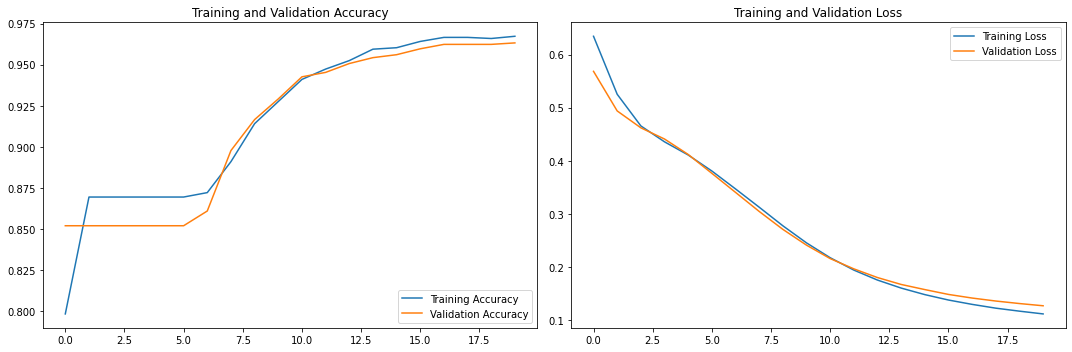

In [20]:
import matplotlib.pyplot as plt
plot_history(history, 20)

In [21]:
inputs = Input(shape=(None,))                  

embed = Embedding(input_dim=embedding_matrix.shape[0],  
                 output_dim=embedding_matrix.shape[1],   
                  embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix), 
                  trainable=True,                       
                 mask_zero=True)(inputs)                 

 
conv1d = Conv1D(filters=100, kernel_size=2, activation='relu')(embed)

global_maxpool = GlobalAveragePooling1D()(conv1d)
dense = Dense(units=2, activation='softmax')(global_maxpool)
model = Model(inputs=inputs,
              outputs=dense)

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 300)         120000600 
                                                                 
 conv1d_1 (Conv1D)           (None, None, 100)         60100     
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 120,060,902
Trainable params: 120,060,902
Non-trainable params: 0
_____________________________________________

In [22]:

history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=20,
                    validation_data=(X_valid, y_valid)) 

Epoch 1/20
9/9 [==============================] - 1s 73ms/step - loss: 0.6050 - accuracy: 0.8168 - val_loss: 0.5009 - val_accuracy: 0.8520
Epoch 2/20
9/9 [==============================] - 1s 57ms/step - loss: 0.4270 - accuracy: 0.8695 - val_loss: 0.4243 - val_accuracy: 0.8520
Epoch 3/20
9/9 [==============================] - 1s 57ms/step - loss: 0.3928 - accuracy: 0.8695 - val_loss: 0.4162 - val_accuracy: 0.8520
Epoch 4/20
9/9 [==============================] - 1s 56ms/step - loss: 0.3618 - accuracy: 0.8695 - val_loss: 0.3728 - val_accuracy: 0.8520
Epoch 5/20
9/9 [==============================] - 1s 57ms/step - loss: 0.3352 - accuracy: 0.8695 - val_loss: 0.3387 - val_accuracy: 0.8520
Epoch 6/20
9/9 [==============================] - 1s 57ms/step - loss: 0.2945 - accuracy: 0.8695 - val_loss: 0.2939 - val_accuracy: 0.8520
Epoch 7/20
9/9 [==============================] - 1s 57ms/step - loss: 0.2437 - accuracy: 0.8787 - val_loss: 0.2360 - val_accuracy: 0.8924
Epoch 8/20
9/9 [===========

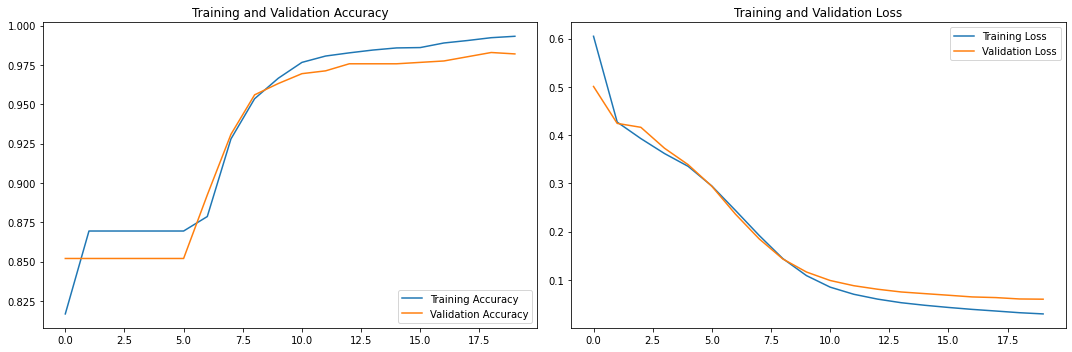

In [23]:
plot_history(history, 20)

Nhận xét: khi không thực hiện train các tham số của Embedding Layer, tức tham số trainable = False. Đồng nghĩa với việc các tham số này không được cập nhật trong quá trình training. Dẫn đến độ chính xác của mô hình có thấp hơn việc ta thiết lập trainable = True. Nghĩa là, tham số của Embedding Layer lúc này được cập nhật trong quá trình training, dẫn đến độ chính xác có tốt hơn. Tuy nhiên, điều này cũng đánh đổi lại việc mô hình sẽ trở nên phức tạp hơn, có kích thước lớn hơn.